# Project Ranking Over Time

In this notebook, we would like to understand the project rankings and how they vary over time for different CNCF projects. Using the graphical techniques such as PageRank, Betweenness and Closeness Centrality scores we can identify the rank for each project in a given time range.

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [1]:
import pandas as pd
import psycopg2
import itertools
import collections
from operator import itemgetter
import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from ipynb.fs.defs.graph_helper_functions import (
     get_repos,
     get_issue_contributors,
     get_pr_contributors,
     get_commit_contributors,
     get_prr_contributors,
     created_melted_dfs,
     get_repos_outside,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("../copy_cage-padres.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
READ_LOCALLY = True

## Retrieve Available Repositories

We start by feeding an initial list of CNCF projects out of which we track projects in 3 categories:

1. Graduated projects - projects that are considered stable, widely adopted and production ready, attracting thousands of contributors
2. Incubating projects - projects used successfully in production by a small number of users
3. Sandbox projects - experimental projects not yet widely tested in production on the bleeding edge of technology

In [4]:
with open('../repo_lists/sandbox_cncf_repos.txt', 'r') as f:
    sandbox_projects = [line.strip() for line in f]

In [5]:
repo_set_sandbox, repo_name_set_sandbox = get_repos(sandbox_projects, engine)

In [6]:
org_repo_sandbox= [x.split("https://github.com/", 1)[1] for x in repo_name_set_sandbox]

In [7]:
org_repo_set = org_repo_sandbox

In [8]:
repo_set = repo_set_sandbox

In [9]:
if READ_LOCALLY:

    issue_contrib = pd.read_pickle("ep_data/issue_contrib.pkl")
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    issue_contrib = get_issue_contributors(repo_set, engine)
    issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date
    date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2013-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2023-06-30'))
    issue_contrib = issue_contrib.loc[date_range]
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    issue_contrib.to_pickle("ep_data/issue_contrib.pkl")

In [10]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,action,issue_id,created_at,created_at_dt,org_repo
0,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,closed,845973,2022-07-25 18:01:18,2022-07-25,keylime/keylime
1,30910,https://github.com/keylime/keylime,keylime,01001c95-c400-0000-0000-000000000000,closed,846089,2021-03-24 22:01:25,2021-03-24,keylime/keylime
2,30910,https://github.com/keylime/keylime,keylime,01019296-d200-0000-0000-000000000000,closed,846019,2020-04-03 17:46:56,2020-04-03,keylime/keylime
3,30910,https://github.com/keylime/keylime,keylime,01019296-d200-0000-0000-000000000000,closed,846050,2019-11-18 08:40:04,2019-11-18,keylime/keylime
4,30910,https://github.com/keylime/keylime,keylime,01006bb5-fa00-0000-0000-000000000000,closed,846219,2019-03-14 16:32:56,2019-03-14,keylime/keylime


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [11]:
if READ_LOCALLY:

    pr_contrib = pd.read_pickle("ep_data/pr_contrib.pkl")
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    pr_contrib = get_pr_contributors(repo_set, engine)
    pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date
    #date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2013-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2023-06-30'))
    pr_contrib = pr_contrib.loc[date_range]
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    pr_contrib.to_pickle("ep_data/pr_contrib.pkl")

In [12]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt,org_repo
0,30910,https://github.com/keylime/keylime,keylime,0100a497-e300-0000-0000-000000000000,4036942,2022-09-26 20:12:52,2022-09-26,keylime/keylime
1,30910,https://github.com/keylime/keylime,keylime,0102c990-e500-0000-0000-000000000000,11735690,2022-10-10 20:22:28,2022-10-10,keylime/keylime
2,30910,https://github.com/keylime/keylime,keylime,01001edd-e300-0000-0000-000000000000,11735690,2022-10-10 20:22:28,2022-10-10,keylime/keylime
3,30910,https://github.com/keylime/keylime,keylime,01001c95-c400-0000-0000-000000000000,101390899,2023-05-22 22:22:11,2023-05-22,keylime/keylime
4,30910,https://github.com/keylime/keylime,keylime,0102c990-e500-0000-0000-000000000000,101390899,2023-05-22 22:22:11,2023-05-22,keylime/keylime


In [13]:
pr_contrib.created_at_dt.min()

datetime.date(2014, 12, 23)

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [14]:
if READ_LOCALLY:
    commit_contrib = pd.read_pickle("ep_data/commit_contrib.pkl")
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:
    commit_contrib = get_commit_contributors(repo_set, engine)
    commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date
    date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2013-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2023-06-30'))
    commit_contrib = commit_contrib.loc[date_range]
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    commit_contrib.to_pickle("ep_data/commit_contrib.pkl")  

In [15]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt,org_repo
0,30910,https://github.com/keylime/keylime,keylime,010007cc-6000-0000-0000-000000000000,120784355,2020-01-26,2020-01-26,keylime/keylime
1,30910,https://github.com/keylime/keylime,keylime,01003859-5400-0000-0000-000000000000,120784589,2020-12-16,2020-12-16,keylime/keylime
2,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,120784879,2021-08-02,2021-08-02,keylime/keylime
3,30910,https://github.com/keylime/keylime,keylime,01003859-5400-0000-0000-000000000000,120784602,2020-12-16,2020-12-16,keylime/keylime
4,30910,https://github.com/keylime/keylime,keylime,010007cc-6000-0000-0000-000000000000,120784356,2020-01-26,2020-01-26,keylime/keylime


### Retrieve PR Reviewers 

We will now fetch all the PR Reviewers for various repositories.

In [16]:
if READ_LOCALLY:

    prr_contrib = pd.read_pickle("ep_data/prr_contrib.pkl")
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    prr_contrib = get_prr_contributors(repo_set, engine)
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    prr_contrib.to_pickle("ep_data/prr_contrib.pkl")  

In [17]:
prr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,org_repo
0,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,4036942,keylime/keylime
1,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,11735690,keylime/keylime
2,30910,https://github.com/keylime/keylime,keylime,0100a5a0-0e00-0000-0000-000000000000,4036942,keylime/keylime
3,30910,https://github.com/keylime/keylime,keylime,0100a5a0-0e00-0000-0000-000000000000,2320921,keylime/keylime
4,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,20635784,keylime/keylime


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [18]:
commit_contrib.cmt_date_attempted_dt.min()

datetime.date(2013, 5, 15)

In [19]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt,org_repo
0,30910,https://github.com/keylime/keylime,keylime,010007cc-6000-0000-0000-000000000000,120784355,2020-01-26,2020-01-26,keylime/keylime
1,30910,https://github.com/keylime/keylime,keylime,01003859-5400-0000-0000-000000000000,120784589,2020-12-16,2020-12-16,keylime/keylime
2,30910,https://github.com/keylime/keylime,keylime,0100005d-0700-0000-0000-000000000000,120784879,2021-08-02,2021-08-02,keylime/keylime
3,30910,https://github.com/keylime/keylime,keylime,01003859-5400-0000-0000-000000000000,120784602,2020-12-16,2020-12-16,keylime/keylime
4,30910,https://github.com/keylime/keylime,keylime,010007cc-6000-0000-0000-000000000000,120784356,2020-01-26,2020-01-26,keylime/keylime


In [20]:
df_commit = commit_contrib.groupby(['org_repo', 'cntrb_id', 'cmt_date_attempted_dt']).size().unstack(fill_value=0)
df_commit = df_commit.reset_index()
df_commit.head()

cmt_date_attempted_dt,org_repo,cntrb_id,2013-05-15,2013-05-16,2013-05-24,2013-05-28,2013-05-29,2013-05-30,2013-06-03,2013-06-04,...,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10
0,WasmEdge/WasmEdge,010003d7-c900-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WasmEdge/WasmEdge,0100042e-7900-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WasmEdge/WasmEdge,01002a5e-b400-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WasmEdge/WasmEdge,01003291-1b00-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WasmEdge/WasmEdge,01006c29-c300-0000-0000-000000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_melted_commit = df_commit.melt(
    id_vars=['org_repo', 'cntrb_id'],
    var_name = 'date', value_name='number'
)
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[3]] != 0]
df_melted_commit.head()

,org_repo,cntrb_id,date,number
335,distribution/distribution,010007f5-e500-0000-0000-000000000000,2013-05-15,11
1625,distribution/distribution,010007f5-e500-0000-0000-000000000000,2013-05-16,2
2951,distribution/distribution,01000fc1-4700-0000-0000-000000000000,2013-05-24,2
4113,distribution/distribution,01000073-7d00-0000-0000-000000000000,2013-05-28,1
4205,distribution/distribution,010007f5-e500-0000-0000-000000000000,2013-05-28,1


#### Create melted dataframes for all contribution type dataframes

In [22]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
#df_melted_prr_contrib = created_melted_dfs(prr_contrib)

In [23]:
df_melted_pr_contrib.head()

,org_repo,cntrb_id,date,number
1081,distribution/distribution,010017dd-9600-0000-0000-000000000000,2014-12-23,1
1395,distribution/distribution,0104a7a6-8300-0000-0000-000000000000,2014-12-23,1
4342,distribution/distribution,010001d7-1900-0000-0000-000000000000,2014-12-24,1
4515,distribution/distribution,010017dd-9600-0000-0000-000000000000,2014-12-24,1
4829,distribution/distribution,0104a7a6-8300-0000-0000-000000000000,2014-12-24,4


In [24]:
df_melted_issue_contrib.head()

,org_repo,cntrb_id,date,number
469,distribution/distribution,01000e11-a200-0000-0000-000000000000,2015-01-02,1
2541,distribution/distribution,010001d7-1900-0000-0000-000000000000,2015-01-06,1
2562,distribution/distribution,01000514-9200-0000-0000-000000000000,2015-01-06,2
4693,distribution/distribution,01000514-9200-0000-0000-000000000000,2015-01-08,1
6824,distribution/distribution,01000514-9200-0000-0000-000000000000,2015-01-14,1


### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [63]:
commit_issue = pd.concat([df_melted_commit, df_melted_issue_contrib]).groupby(["org_repo", "cntrb_id", "date"]).sum().reset_index()
merged_df = pd.concat([df_melted_pr_contrib, commit_issue]).groupby(["org_repo", "cntrb_id", "date"]).sum().reset_index()
#merged_df = pd.concat([comm_issue_pr_df, df_melted_prr_contrib]).groupby(["org_repo", "cntrb_id", "date"]).sum().reset_index()
merged_df.rename(columns = {'number':'total_contributions'}, inplace = True)

In [64]:
merged_df.head()

,org_repo,cntrb_id,date,total_contributions
0,WasmEdge/WasmEdge,01000022-0200-0000-0000-000000000000,2022-12-15,1
1,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2020-06-08,1
2,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-05,1
3,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-25,3
4,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-27,3


In [65]:
len(merged_df)

66170

In [66]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66170 entries, 0 to 66169
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   org_repo             66170 non-null  object        
 1   cntrb_id             66170 non-null  object        
 2   date                 66170 non-null  datetime64[ns]
 3   total_contributions  66170 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.0+ MB


In [68]:
merged_df['year'] = merged_df['date'].dt.year

In [69]:
merged_df.head()

,org_repo,cntrb_id,date,total_contributions,year
0,WasmEdge/WasmEdge,01000022-0200-0000-0000-000000000000,2022-12-15,1,2022
1,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2020-06-08,1,2020
2,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-05,1,2021
3,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-25,3,2021
4,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021-05-27,3,2021


In [70]:
grouped_df = merged_df.groupby(['org_repo', 'cntrb_id', 'year'])['total_contributions'].sum()

In [71]:
grouped_df = grouped_df.reset_index()
grouped_df.head()

,org_repo,cntrb_id,year,total_contributions
0,WasmEdge/WasmEdge,01000022-0200-0000-0000-000000000000,2022,1
1,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2020,1
2,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2021,42
3,WasmEdge/WasmEdge,0100002a-3600-0000-0000-000000000000,2022,9
4,WasmEdge/WasmEdge,0100004b-6300-0000-0000-000000000000,2022,1


In [60]:
len(grouped_df)

6745

### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. 

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

In [28]:
repo_scores = pd.DataFrame(
    {'repo': org_repo_sandbox
    })

In [29]:
#  A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. 
#  Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.
bidirect_df = merged_df.append(merged_df.rename(columns={"org_repo":"cntrb_id", "cntrb_id":"org_repo"}))

/tmp/ipykernel_1843/2858595225.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bidirect_df = merged_df.append(merged_df.rename(columns={"org_repo":"cntrb_id", "cntrb_id":"org_repo"}))


In [30]:
# Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='org_repo',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

In [31]:
repos = {"repo_name_set_sandbox": org_repo_sandbox}

In [32]:
top_repos, pageranks, repo_scores = get_page_ranks(H, 100, repos, repo_scores)

In [35]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:10])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)

In [36]:
t = "Top 10 repos by page rank"

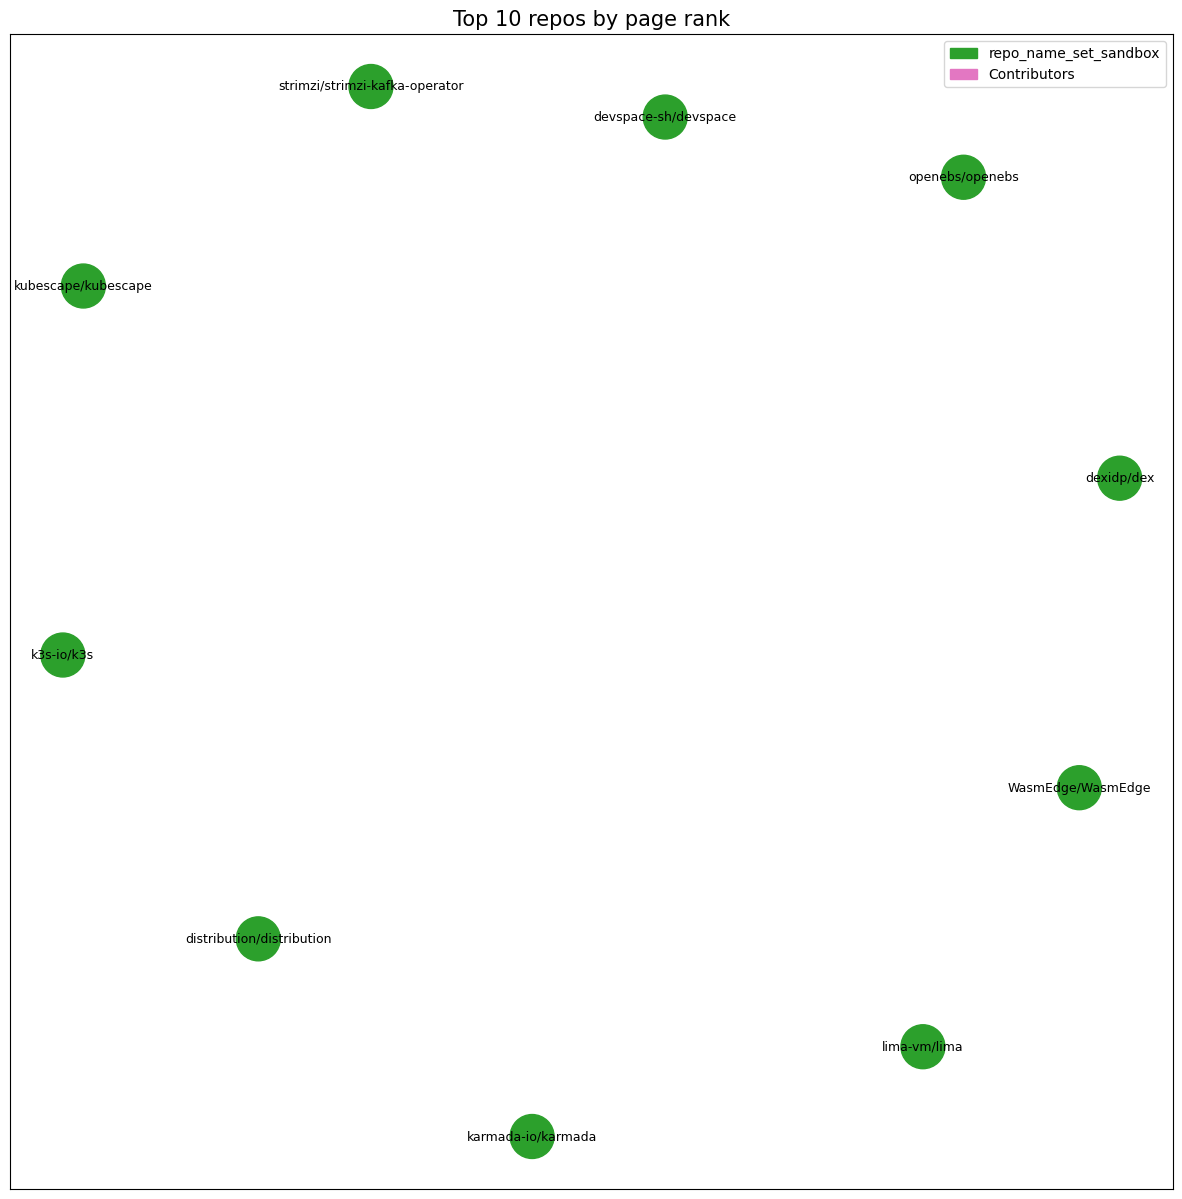

In [37]:
plot_graph(subgraph, repos, 'conditional', t, org_repo_set , True, None, 'k')